In [9]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics._scorer import make_scorer
import numpy as np
from loguru import logger
import matplotlib.pyplot as plt

import missingno as msno
# from scipy.stats import randint

# from utils import SpaceTimeSplits
# from metrics import get_metrics

# pd.options.mode.chained_assignment = None   # to disable chained assignment warning (by default, this is "warn")

In [2]:
# train_data = pd.read_csv("../data/train_clean_v1.csv")
train_data = pd.read_csv("../data/train_raw.csv")
val_data = pd.read_csv("../data/validation_v1.csv")

/var/folders/1l/36wkr52s0qg1mbnfl6h1v30m0000gn/T/ipykernel_51882/228957105.py:2: DtypeWarning: Columns (176,180,182) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("../data/train_raw.csv")


In [52]:
labels = ["value"]
to_discard_cols = [
    "Unnamed: 0",   # just the row number
    "space_group",
    "lat_group",
    "long_group",
    "time_group",
    ".partitions",
    "TZID", #timezone id (all are UTC)
    "dswe",     # all are 1
    "source",   #all are "WQP"
    "characteristicName",   # all are TSS
    "parameter",   # all are TSS
    "harmonized_unit",  # same values for all rows (mg/l)
    "date_only",    # all are False
]

In [57]:
train_data.nunique().sort_values()

sat             3
type            4
row            18
path           36
n              50
            ...  
B.NS        27318
B.RN        27332
swir1_sd    27994
rn          28933
uniqueID    28933
Length: 96, dtype: int64

In [58]:
train_data.describe()

,azimuth,dswe_sd,path,pixelCount,row,swir1_sd,zenith,area.km2,long,lat,...,ndssi,gn.gn,hue,saturation,bright,bright_tot,dw,uniqueID,n,julian
count,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,...,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000,28933.000000
mean,135.837955,0.134658,19.622092,76.366675,34.783085,72.690374,39.306084,30960.804616,-84.698815,36.371273,...,0.064218,0.157310,0.346551,0.292426,0.023701,1780.543930,538.281685,61127.287077,26294.714098,13184.805101
std,16.023701,0.160863,7.026450,49.721178,4.288151,61.251222,12.017101,64.716157,10.007633,6.141088,...,0.237249,0.221267,0.137936,0.115170,0.011047,846.177510,32.714100,37529.117996,14951.860524,2512.215536
min,86.982834,0.000000,12.000000,3.000000,26.000000,0.000000,20.385475,30822.395738,-124.093031,25.141030,...,-0.925082,-0.378596,0.000000,0.000000,0.003515,215.000000,380.000000,1.000000,11.000000,5215.000000
25%,125.690483,0.000000,15.000000,28.000000,32.000000,27.919007,28.910625,30917.655181,-89.786972,30.238056,...,-0.109440,-0.009189,0.242297,0.213018,0.015900,1164.587068,508.000000,29336.000000,10591.000000,11640.000000
50%,138.233353,0.000000,16.000000,73.000000,34.000000,52.595231,36.480495,30950.225183,-81.650972,37.693300,...,0.041860,0.130902,0.353332,0.285484,0.021755,1621.729428,548.000000,58422.000000,29407.000000,13347.000000
75%,148.300949,0.253395,23.000000,136.000000,39.000000,100.581701,49.142551,31026.560047,-76.744200,40.478900,...,0.221854,0.307059,0.447122,0.362869,0.029093,2212.052925,564.000000,91374.000000,32784.000000,14903.000000
max,166.669846,0.500000,47.000000,143.000000,43.000000,1332.972941,72.856476,31078.731996,-69.577270,49.000556,...,0.977669,0.977209,0.998881,0.942369,0.145566,9181.268236,699.000000,152264.000000,44680.000000,17696.000000


# Remove irrelevant features

In [53]:
ctr = 0
tot_ctr = 0
incomplete_cols = []
for col in train_data.columns:
    if col in labels or col in to_discard_cols:
        continue
    tot_ctr += 1
    num_missing = np.sum(train_data[col].isnull())
    if num_missing>0:
        ctr += 1
        # print(col, num_missing)
        incomplete_cols.append(col)
print(f"Found {ctr} out of {tot_ctr} features with missing values")

# Remove cols with missing values
for col in incomplete_cols:
    if col in train_data.columns:
        train_data = train_data.drop(col, axis=1)
# Remove uninformative columns
for col in to_discard_cols:
    if col in train_data.columns:
        train_data = train_data.drop(col, axis=1)

Found 0 out of 95 features with missing values


<AxesSubplot: >

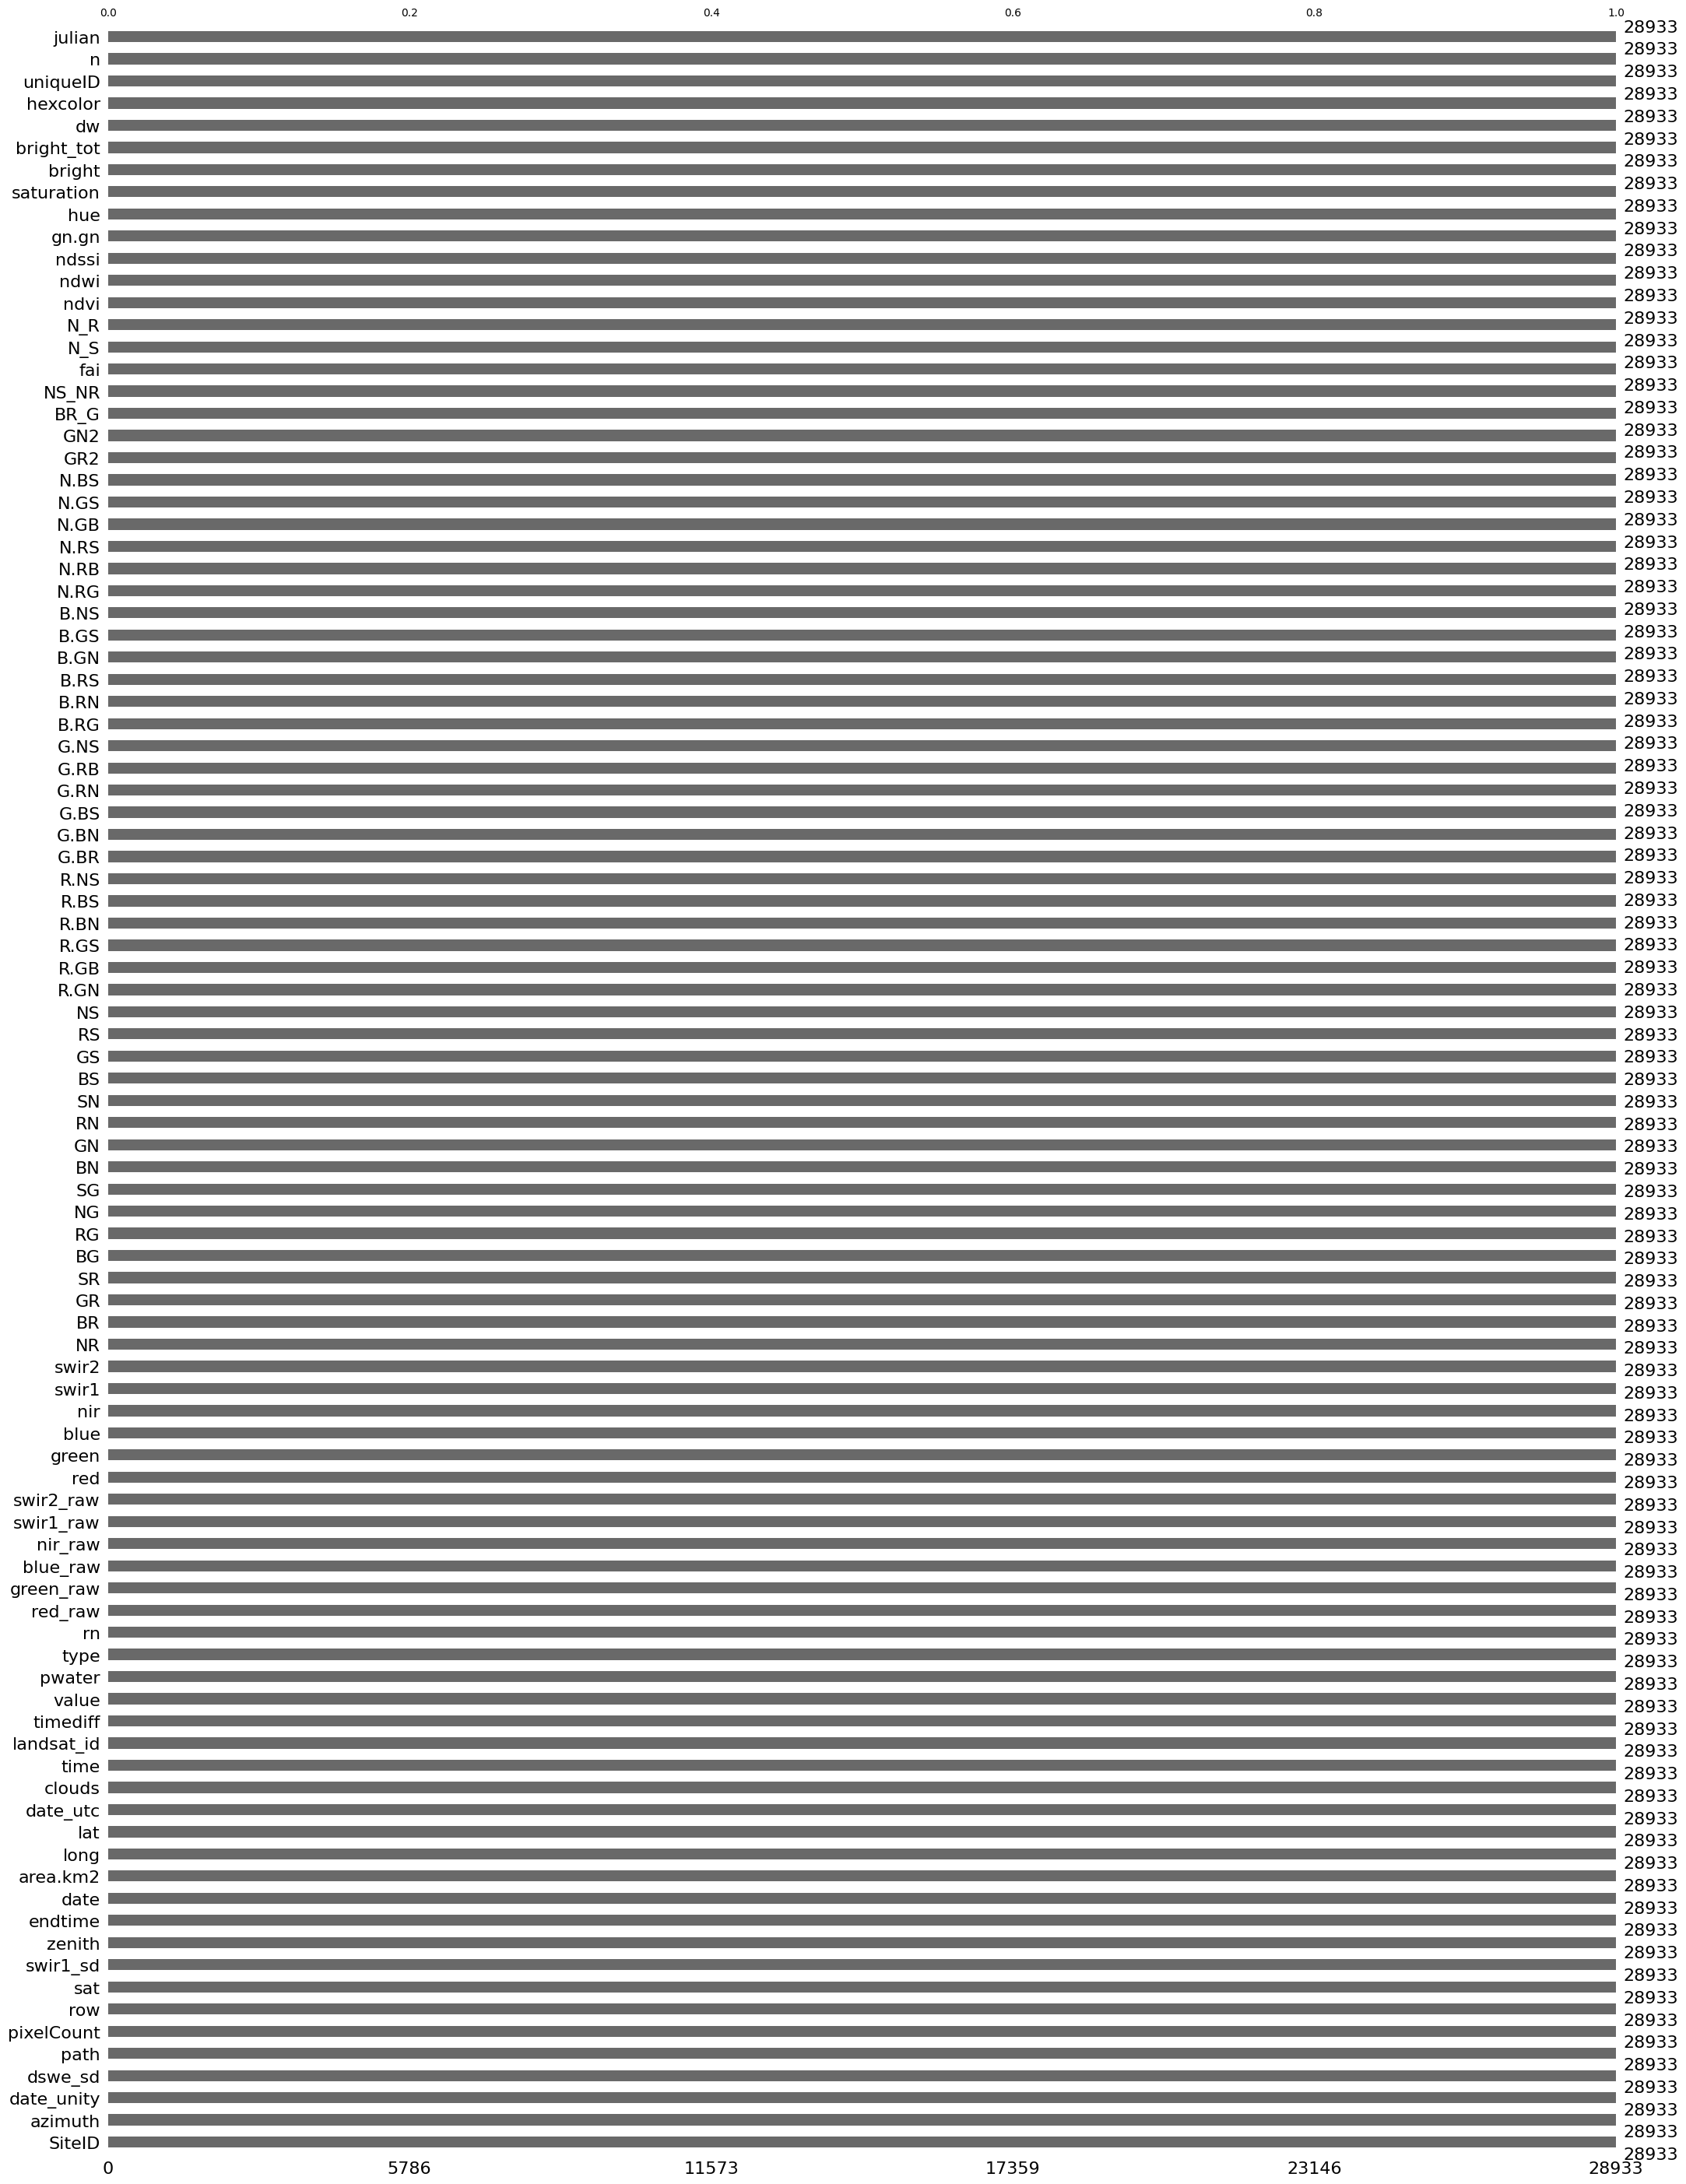

In [59]:
msno.bar(train_data)

In [35]:
train_data["type"].value_counts()

Stream      12850
Estuary      8378
Lake         7524
Facility      181
Name: type, dtype: int64

In [60]:
train_data.shape

(28933, 96)

Left with 96 columns/features after cleaning (includes the label)

# Plot correlation between features

In [63]:
import pandas as pd
import numpy as np

rs = np.random.RandomState(0)
# df = pd.DataFrame(rs.rand(10, 10))
corr = train_data.corr()
corr.style.background_gradient(cmap='coolwarm')

/var/folders/1l/36wkr52s0qg1mbnfl6h1v30m0000gn/T/ipykernel_51882/4221770215.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_data.corr()
